Import libraries

In [106]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

Read Data and visualize them

We will simulate movement of any object. For estimation of position, there are 3 factors: "Initial position", "Velocity", "Acceleration".
</br>
Our formula for position looks then like this
</br>
<img src="images/Kynetics.png" />
</br>
We have to transform this formula into matrix multiplication. As we work with dicrete time "k" is our coeficient of time shift and "delta t" is our increment of time for one coeficient. 
</br>
<img src="images/position_formula_discrete.png" />


Lets calculate simulation using different time increments simulating discrete calculation

In [60]:
# define the true parameters that we want to estimate
 
# true value of the parameters that will be estimated 
initialPosition=100
acceleration=1
initialVelocity=2
 
# noise standard deviation
noiseStd=1;
 
# simulation time
end_time = 30
increment = 0.01
number_of_increments = int(end_time/increment)+1
# vector used to store the somulated position
position=np.zeros(number_of_increments)

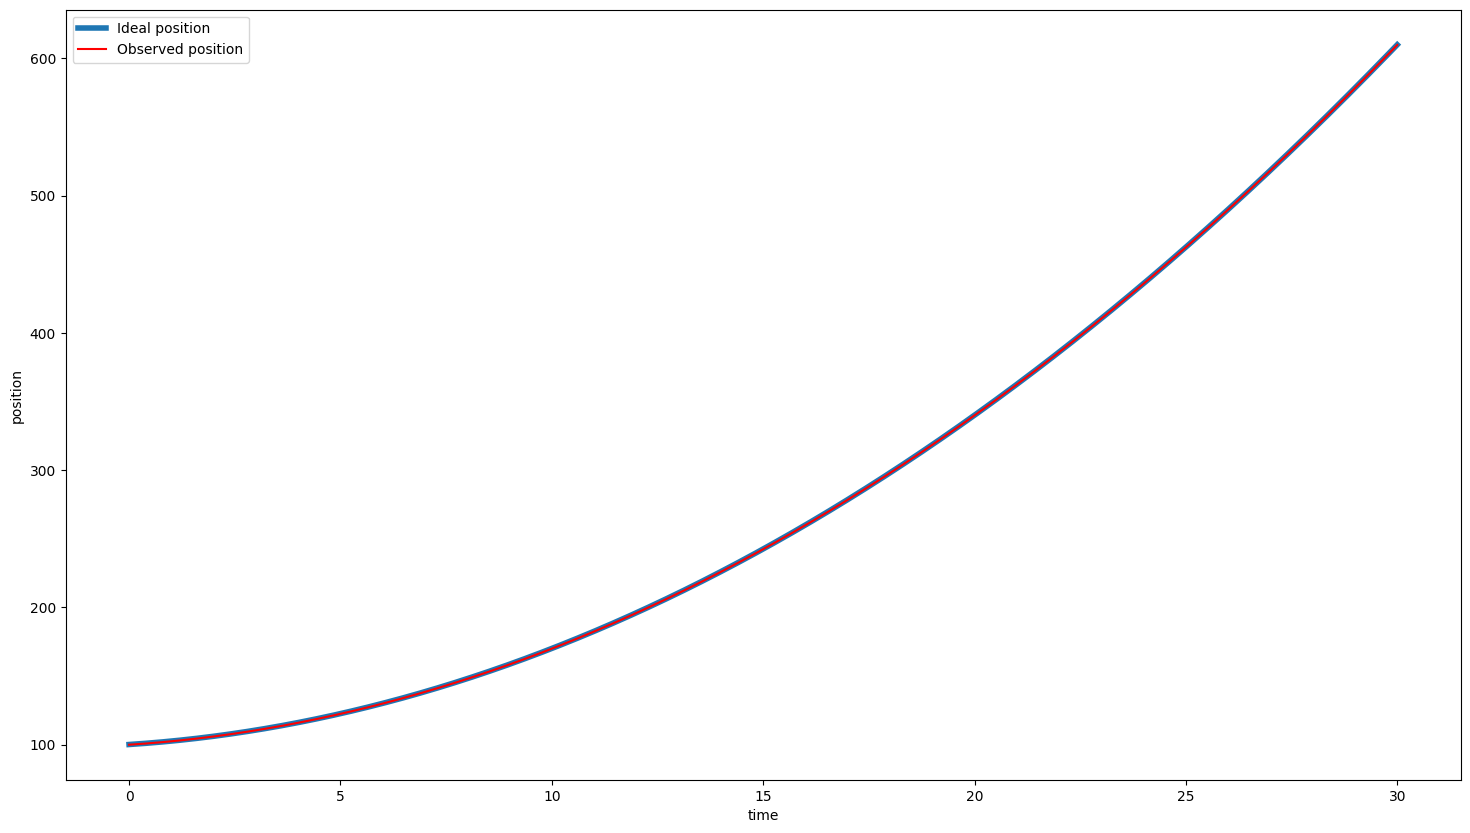

In [61]:
# simulate the system behavior
# simulate the system behavior
simulationTime=np.zeros((number_of_increments))
for i in range(number_of_increments):
    time = i*increment
    simulationTime[i] = time
    position[i]=initialPosition+initialVelocity*time+(acceleration*time**2)/2
 
# add the measurement noise 
positionNoisy=position+noiseStd*np.random.randn(np.size(number_of_increments))
 
# verify the position vector by plotting the results
plotStep=1000000
plt.figure(figsize=(18,10))
plt.plot(simulationTime[0:plotStep],position[0:plotStep],linewidth=4, label='Ideal position')
plt.plot(simulationTime[0:plotStep],positionNoisy[0:plotStep],'r', label='Observed position')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.savefig('data.png',dpi=300)
plt.show()

Lets calculate simulation using different time increments simulating continuos calculation

In [62]:
# define the true parameters that we want to estimate
 
# true value of the parameters that will be estimated 
initialPosition=100
acceleration=1
initialVelocity=2
 
# noise standard deviation
noiseStd=1;
 
# simulation time
simulationTime=np.linspace(0,30,4000)
# vector used to store the somulated position
position=np.zeros(np.size(simulationTime))

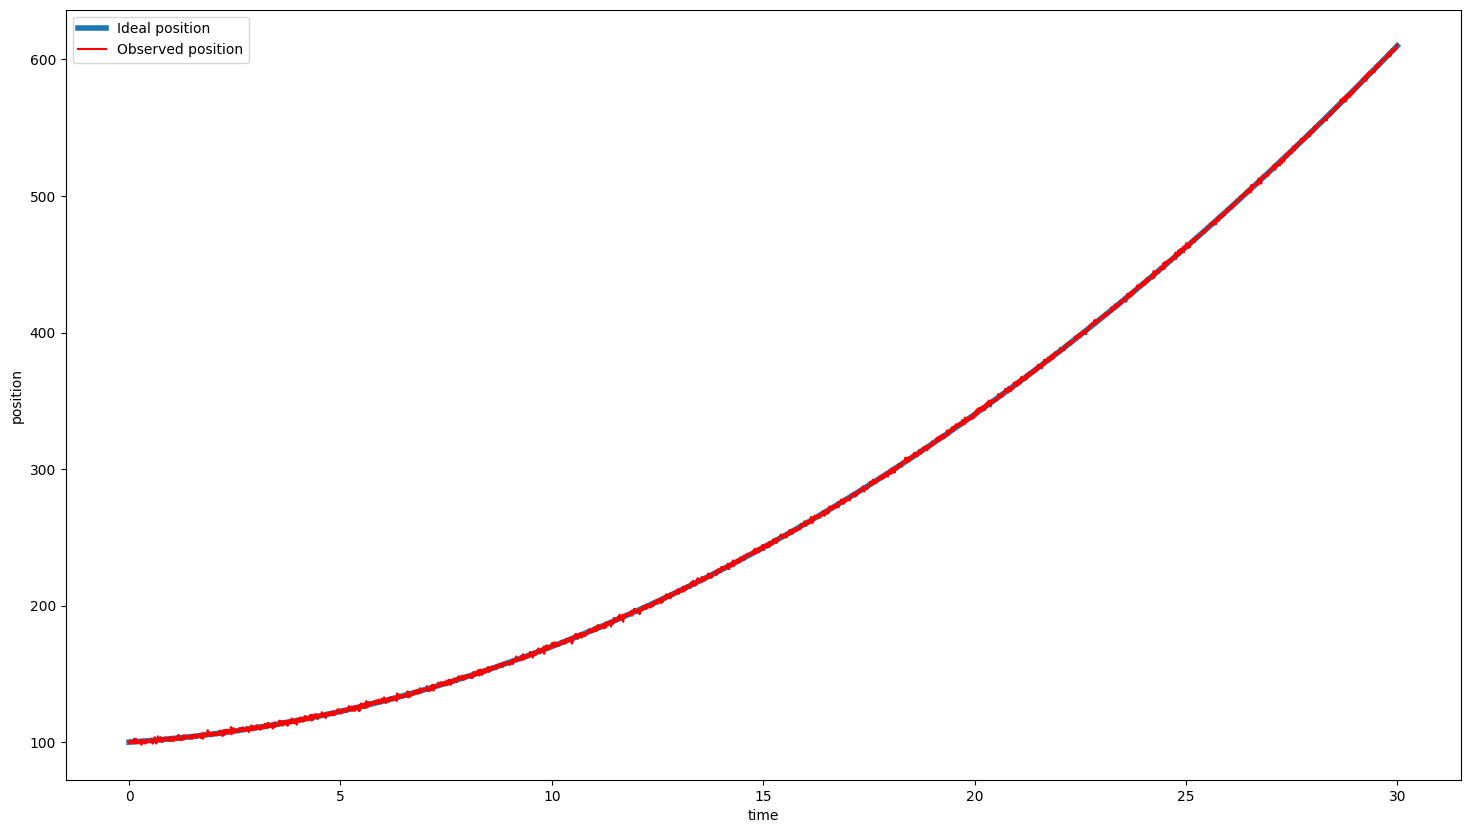

In [63]:
# simulate the system behavior
for i in np.arange(np.size(simulationTime)):
    position[i]=initialPosition+initialVelocity*simulationTime[i]+(acceleration*simulationTime[i]**2)/2
 
# add the measurement noise 
positionNoisy=position+noiseStd*np.random.randn(np.size(simulationTime))
 
# verify the position vector by plotting the results
plotStep=1000000
plt.figure(figsize=(18,10))
plt.plot(simulationTime[0:plotStep],position[0:plotStep],linewidth=4, label='Ideal position')
plt.plot(simulationTime[0:plotStep],positionNoisy[0:plotStep],'r', label='Observed position')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.savefig('data.png',dpi=300)
plt.show()

We would like to estimate the position. For this purpore we will use linear formula. 
</br>
<img src="images/lin_form.png"  width = 200 height=100 />
</br>
We assume noise estimation equals to 0.
</br>
<img src="images/noise_estimation.png" width = 200 height=100 />
</br>
Our equation can be written as:
</br>
<img src="images/Recursive_LSE_formula.png" width = 200 height=100 />
</br>
From this we can state our error that is equal to optimal x minus our estimate
</br>
<img src="images/Recursive_LSE_error.png" width = 200 height=100 />
</br>
From this simple formula we need to derive estimation error which looks like this. Its basically only puting formula for yk and multiplying pieces of formula. 
</br>
<img src="images/Recursive_LSE_estimation_error.png" width = 300 height=150 />
</br>
From our estimation error matrix, we would like to get covariance matrix Pk. That means we use same formula of e*eT to get power of 2. This give us very complicated formula as bellow
</br>
<img src="images/Recursive_LSE_covariance_before.png" width = 300 height=150 />
</br>
And after simplification, where we know that vk is equal to 0, vk*vkT is equal to Rk and ek-1*ek-1 is equal to Pk-1, we get following formula. This is our covariance matrix Pk
</br>
<img src="images/Recursive_LSE_covariance_after.png" width = 300 height=50 />
</br>
Now we need to get our gain matrix Kk, that means partial derivative in respect to Kk, which equals to 0. That brings us following fomrula. 
</br>
<img src="images/Recursive_LSE_gain_derivative.png" width = 300 height=100 />
</br>
Which after simplification gives us final formula for gain matrix
</br>
<img src="images/Recursive_LSE_gain_matrix.png" width = 400 height=200 />
</br>
So, we have all 3 formulas. Gain matrix Kk, parameters of xk and covariance matrix of pk. 
</br>
<img src="images/Recursive_LSE_all_formulas.png" width = 400 height=200 />

In our case for H measumerement we will use delta of time, which is for us 1 day or we can use as increase of 1 per record and we would like to be predicting close price. We decided to measure certainty of measurement sigma^2 based on date of measurement, therefore we need to calculate sigma and later apply it.

### Implement Recursive LS class

In [64]:
class RecursiveLeastSquares(object):
     
    # x0 - initial estimate used to initialize the estimator
    # P0 - initial estimation error covariance matrix
    # R  - covariance matrix of the measurement noise
    def __init__(self,x0,P0,R):
         
        # initialize the values
        self.x0=x0
        self.P0=P0
        self.R=R
         
        # this variable is used to track the current time step k of the estimator 
        # after every time step arrives, this variables increases for one 
        # in this way, we can track the number of variblaes
        self.currentTimeStep=0
                   
        # this list is used to store the estimates xk starting from the initial estimate 
        self.estimates=[]
        self.estimates.append(x0)
          
        # this list is used to store the estimation error covariance matrices Pk
        self.estimationErrorCovarianceMatrices=[]
        self.estimationErrorCovarianceMatrices.append(P0)
         
        # this list is used to store the gain matrices Kk
        self.gainMatrices=[]
          
        # this list is used to store estimation error vectors
        self.errors=[]

        # List of predictions
        self.predictions = []
     
      
    # this function takes the current measurement and the current measurement matrix C
    # and computes the estimation error covariance matrix, updates the estimate, 
    # computes the gain matrix, and the estimation error
    # it fills the lists self.estimates, self.estimationErrorCovarianceMatrices, self.gainMatrices, and self.errors
    # it also increments the variable currentTimeStep for 1
     
    # measurementValue - measurement obtained at the time instant k
    # C - measurement matrix at the time instant k
     
    def predict(self,measurementValue,C):
         
        # compute the L matrix and its inverse, see Eq. 43
        Lmatrix=self.R+np.matmul(C,np.matmul(self.estimationErrorCovarianceMatrices[self.currentTimeStep],C.T))
        LmatrixInv=np.linalg.inv(Lmatrix)
        # compute the gain matrix, see Eq. 42 or Eq. 48
        gainMatrix=np.matmul(self.estimationErrorCovarianceMatrices[self.currentTimeStep],np.matmul(C.T,LmatrixInv))
 
        # compute the estimation error
        prediction = np.matmul(C,self.estimates[self.currentTimeStep])                    
        error=measurementValue-prediction
        # compute the estimate, see Eq. 49
        estimate=self.estimates[self.currentTimeStep]+np.matmul(gainMatrix,error)
         
        # propagate the estimation error covariance matrix, see Eq. 50            
        ImKc=np.eye(np.size(self.x0),np.size(self.x0))-np.matmul(gainMatrix,C)
        estimationErrorCovarianceMatrix=np.matmul(ImKc,self.estimationErrorCovarianceMatrices[self.currentTimeStep])
         
        # add computed elements to the list
        self.predictions.append(prediction)
        self.estimates.append(estimate)
        self.estimationErrorCovarianceMatrices.append(estimationErrorCovarianceMatrix)
        self.gainMatrices.append(gainMatrix)
        self.errors.append(error)
         
        # increment the current time step
        self.currentTimeStep=self.currentTimeStep+1
        
        

### Run Kalman Filter

In [180]:
	
x0=np.random.randn(3,1)
#x0=np.array([[100],[2],[1]])
P0=100*np.eye(3,3) # Large, because I dont know anything, about parameter vector. If I have perfect know exact number, then I would use 0
R=0.001*np.eye(1,1) # Measurement noise covariance matrix.
 
# create a recursive least squares object
RLS=RecursiveLeastSquares(x0,P0,R)
 
# simulate online prediction
for j in np.arange(np.size(simulationTime)):
    C=np.array([[1,simulationTime[j],(simulationTime[j]**2)/2]])
    RLS.predict(positionNoisy[j],C)


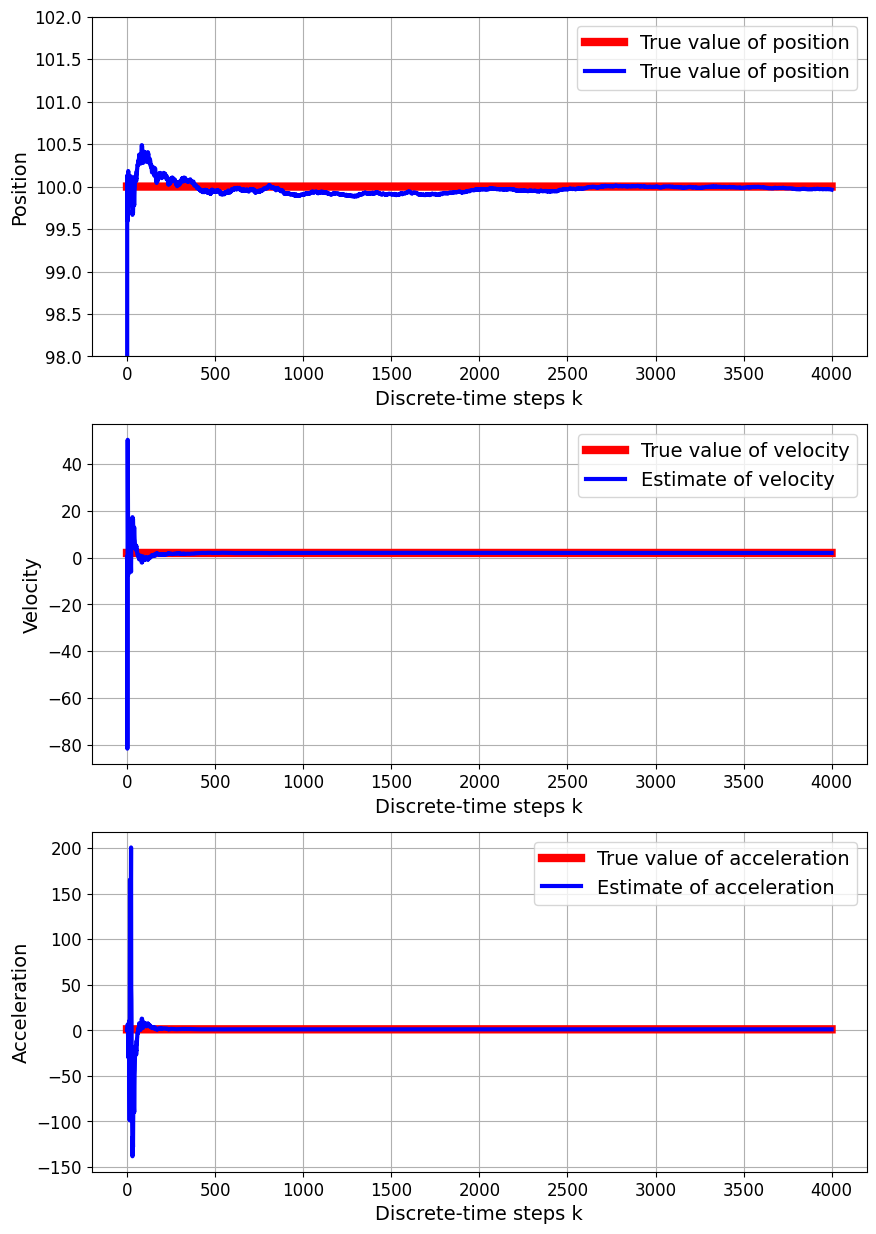

In [185]:
# extract the estimates in order to plot the results
estimate1=[]
estimate2=[]
estimate3=[]    
for j in np.arange(np.size(simulationTime)):
    estimate1.append(RLS.estimates[j][0])
    estimate2.append(RLS.estimates[j][1])
    estimate3.append(RLS.estimates[j][2])
     
# create vectors corresponding to the true values in order to plot the results
estimate1true=initialPosition*np.ones(np.size(simulationTime))
estimate2true=initialVelocity*np.ones(np.size(simulationTime))
estimate3true=acceleration*np.ones(np.size(simulationTime))
 
 
# plot the results
steps=np.arange(np.size(simulationTime))
fig, ax = plt.subplots(3,1,figsize=(10,15))
ax[0].plot(steps,estimate1true,color='red',linestyle='-',linewidth=6,label='True value of position')
ax[0].plot(steps,estimate1,color='blue',linestyle='-',linewidth=3,label='True value of position')
ax[0].set_xlabel("Discrete-time steps k",fontsize=14)
ax[0].set_ylabel("Position",fontsize=14)
ax[0].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
ax[0].set_ylim(98,102)  
ax[0].grid()
ax[0].legend(fontsize=14)
 
ax[1].plot(steps,estimate2true,color='red',linestyle='-',linewidth=6,label='True value of velocity')
ax[1].plot(steps,estimate2,color='blue',linestyle='-',linewidth=3,label='Estimate of velocity')
ax[1].set_xlabel("Discrete-time steps k",fontsize=14)
ax[1].set_ylabel("Velocity",fontsize=14)
ax[1].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
#ax[1].set_ylim(0,2)  
ax[1].grid()
ax[1].legend(fontsize=14)
 
ax[2].plot(steps,estimate3true,color='red',linestyle='-',linewidth=6,label='True value of acceleration')
ax[2].plot(steps,estimate3,color='blue',linestyle='-',linewidth=3,label='Estimate of acceleration')
ax[2].set_xlabel("Discrete-time steps k",fontsize=14)
ax[2].set_ylabel("Acceleration",fontsize=14)
ax[2].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
#ax[1].set_ylim(0,2)  
ax[2].grid()
ax[2].legend(fontsize=14)